In [1]:
# Audio data input specifications
flac_uri              = 's3://ooi-audio'   # cloud storage location for the input audio data
flac_prefix           = 'HYDBBA105_'       # prefix for the audio files
start_date           = '20190112'   # start date for temporal metadata extraction (YYYYMMDD)
end_date             = '20190112'   # end date for temporal metadata extraction (YYYYMMDD)
json_base_dir        = 'metadata/json' # location to store generated metadata in JSON format

# Import package modules
#from pbp.meta_gen.gen_nrs import NRSMetadataGenerator
from pbp.meta_gen.gen_iclisten import IcListenMetadataGenerator
from pbp.logging_helper import create_logger_info
from datetime import datetime

# a logger that only logs messages tagged as info to the console, for more verbose logging
log = create_logger_info(f'icListen_{start_date}_{end_date}')

# Convert the start and end dates to datetime objects
start = datetime.strptime(start_date, "%Y%m%d")
end = datetime.strptime(end_date, "%Y%m%d")

# Create the metadata generator
meta_gen = IcListenMetadataGenerator(
        log=log,
        uri=flac_uri,
        json_base_dir=json_base_dir,
        start=start,
        end=end,
        prefixes=[flac_prefix],
)
#        seconds_per_file=600) # TODO this is wrong whoops

# Generate the metadata - this will generate JSON files in the json_base_dir
meta_gen.run()

IcListenMetadataGenerator 20190112 Generating metadata for 2019-01-12 00:00:00 to 2019-01-12 00:00:00...
IcListenMetadataGenerator 20190112 Searching in s3://ooi-audio/*.wav for wav files that match the search patterns HYDBBA105_* ...
01/HYDBBA105_20190111_23
IcListenMetadataGenerator 20190112 Searching in bucket: ooi-audio-2019 prefixes: ['HYDBBA105_']
IcListenMetadataGenerator 20190112  No data found in ooi-audio-2019
01/HYDBBA105_20190112_00
IcListenMetadataGenerator 20190112 Searching in bucket: ooi-audio-2019 prefixes: ['HYDBBA105_']
Found s3://ooi-audio-2019/01/HYDBBA105_20190112_000000.wav with timestamp 2019-01-12 00:00:00
Found s3://ooi-audio-2019/01/HYDBBA105_20190112_000500.wav with timestamp 2019-01-12 00:05:00
Found s3://ooi-audio-2019/01/HYDBBA105_20190112_001000.wav with timestamp 2019-01-12 00:10:00
Found s3://ooi-audio-2019/01/HYDBBA105_20190112_001500.wav with timestamp 2019-01-12 00:15:00
Found s3://ooi-audio-2019/01/HYDBBA105_20190112_002000.wav with timestamp 2019-

In [3]:
!ls -l {json_base_dir}/2019

total 128
-rw-r--r--@ 1 joeduprey  staff  62944 Jan 30 13:34 20190112.json


In [4]:
import json

# Load JSON data from a file and print it
with open(f'{json_base_dir}/2019/20190112.json', 'r') as file:
    data = json.load(file)

print(json.dumps(data, indent=4))
# NOTE metadata is hard-coded to work with MBARI bit depth and sample rate    bytes_per_sec = 3 * 256e3
# but OOI should be  4 * 64e3, this requires code changes in installed version of mbari-pbp OR we should submit a PR to make it an arg 

[
    {
        "uri": "s3://ooi-audio-2019/01/HYDBBA105_20190112_000000.wav",
        "start": "2019-01-12T00:00:00Z",
        "end": "2019-01-12T00:05:00Z",
        "duration_secs": 300.0,
        "channels": 1
    },
    {
        "uri": "s3://ooi-audio-2019/01/HYDBBA105_20190112_000500.wav",
        "start": "2019-01-12T00:05:00Z",
        "end": "2019-01-12T00:09:59Z",
        "duration_secs": 299.999,
        "channels": 1
    },
    {
        "uri": "s3://ooi-audio-2019/01/HYDBBA105_20190112_001000.wav",
        "start": "2019-01-12T00:10:00Z",
        "end": "2019-01-12T00:15:00Z",
        "duration_secs": 300.0,
        "channels": 1
    },
    {
        "uri": "s3://ooi-audio-2019/01/HYDBBA105_20190112_001500.wav",
        "start": "2019-01-12T00:15:00Z",
        "end": "2019-01-12T00:20:00Z",
        "duration_secs": 300.0,
        "channels": 1
    },
    {
        "uri": "s3://ooi-audio-2019/01/HYDBBA105_20190112_002000.wav",
        "start": "2019-01-12T00:20:00Z",
      

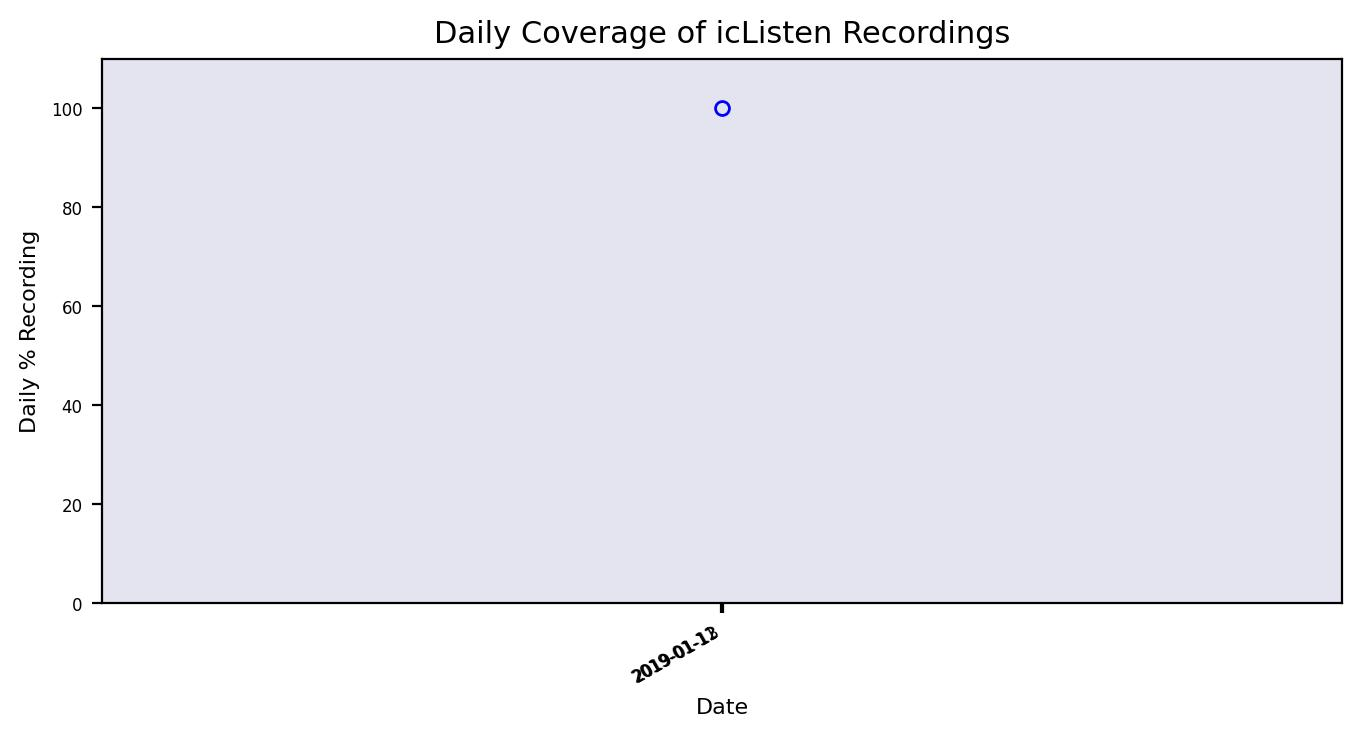

In [5]:
from IPython.display import Image, display

display(Image(filename='metadata/json/iclisten_coverage_20190112_20190112.jpg'))

In [6]:
# hydrophone specification
# NOTE this are placeholder values borrowed from MBARI, OOI will need to get its own attributes and metadata into YAML and NC 
# this is in the works...
voltage_multiplier   = 3       # no change to raw audio required to account for PkPk voltage
sensitivity_uri      = 'metadata/calibration/NRS11_H5R6_sensitivity_hms5kHz.nc'  # hydrophone sensitivity #TODO
subset_to            = (10, 30000)   # subset frequency band for output HMB spectra, recording @ 64 kHz #TODO

# metadata files for output netCDF data products
global_attrs_uri     = 'metadata/attribute/globalAttributes_placeholder.yaml'
variable_attrs_uri   = 'metadata/attribute/variableAttributes_placeholder.yaml'

# output file locations
download_dir         = 'downloads'   # audio files are stored here while being processed
output_dir           = 'output'      # directory to store daily netCDF results and plots
output_prefix        = 'HYDBBA105_'       # a prefix for the name of generate files

# select a day to process (YYYYMMDD format)
date = '20190112'

In [7]:
from pbp.simpleapi import HmbGen

from pbp import get_pbp_version
get_pbp_version()

'1.5.0'

In [8]:
# In this notebook we fetch audio files from public S3 buckets:
import boto3
import botocore
from botocore.config import Config

In [9]:
hmb_gen = HmbGen()

hmb_gen.set_json_base_dir(json_base_dir)
hmb_gen.set_global_attrs_uri(global_attrs_uri)
hmb_gen.set_variable_attrs_uri(variable_attrs_uri)
#hmb_gen.set_sensitivity(sensitivity_uri)
hmb_gen.set_voltage_multiplier(voltage_multiplier)
hmb_gen.set_subset_to(subset_to)

config = Config(signature_version=botocore.UNSIGNED)
s3_client = boto3.client('s3', config=config)
hmb_gen.set_s3_client(s3_client)

hmb_gen.set_download_dir(download_dir)
hmb_gen.set_output_dir(output_dir)
hmb_gen.set_output_prefix(output_prefix)

hmb_gen.set_print_downloading_lines(True)

# ----- JUST FOR INITIAL CONVENIENCE: ------
hmb_gen.set_retain_downloaded_files(True)
hmb_gen.set_assume_downloaded_files(True)

In [10]:
error = hmb_gen.check_parameters()
# A message is returned in case of any errors
if error:
    raise RuntimeError(f"check_parameters returned:\n{error}")

In [11]:
result = hmb_gen.process_date(date)

# The resulting NetCDF file should have been saved under the output directory.

# Here we expose the generated dataset itself to see it displayed in the notebook:
result.dataset

pbp v1.5.0: : Processing 20190112 to generate output/HYDBBA105_20190112.nc...
::: Started processing date='20190112'
Assuming already downloaded s3://ooi-audio-2019/01/HYDBBA105_20190112_000000.wav
Assuming already downloaded s3://ooi-audio-2019/01/HYDBBA105_20190112_000500.wav
Assuming already downloaded s3://ooi-audio-2019/01/HYDBBA105_20190112_001000.wav
Assuming already downloaded s3://ooi-audio-2019/01/HYDBBA105_20190112_001500.wav
Assuming already downloaded s3://ooi-audio-2019/01/HYDBBA105_20190112_002000.wav
Assuming already downloaded s3://ooi-audio-2019/01/HYDBBA105_20190112_002500.wav
Assuming already downloaded s3://ooi-audio-2019/01/HYDBBA105_20190112_003000.wav
Assuming already downloaded s3://ooi-audio-2019/01/HYDBBA105_20190112_003500.wav
Assuming already downloaded s3://ooi-audio-2019/01/HYDBBA105_20190112_004000.wav
Assuming already downloaded s3://ooi-audio-2019/01/HYDBBA105_20190112_004500.wav
Assuming already downloaded s3://ooi-audio-2019/01/HYDBBA105_20190112_005

<xarray.Dataset>
Dimensions:      (time: 1440, frequency: 2264, 1: 1)
Coordinates:
  * time         (time) int64 1547251200 1547251260 ... 1547337480 1547337540
  * frequency    (frequency) float32 10.0 11.0 12.0 ... 2.989e+04 2.996e+04
Dimensions without coordinates: 1
Data variables:
    psd          (time, frequency) float32 41.64 39.97 41.38 ... -19.38 -18.27
    effort       (time) float32 60.0 60.0 60.0 60.0 60.0 ... 60.0 60.0 60.0 60.0
    sensitivity  (1) float32 1.0
Attributes: (12/28)
    title:                     Hybrid Millidecade Band Sound Pressure Levels ...
    Summary:                   To understand natural and anthropogenic sound ...
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    keywords:                  oceans, ocean acoustics, ambient noise, intens...
    keywords_vocabulary:       GCMD Science Keywords
    history:                   Original hybrid millidecade spectra were produ...
    ...                        ...
    time_coverage_duration:    P1D
    time_coverage_resolution:  P60S
    platform:                  NOAA NRS11 mooring
    instrument:                AUH model ITC-1032, SN H23
    cdm_data_type:             TimeSeries
    references:                Computation of single-sided mean-square sound ...

In [16]:
from pbp.plotting import plot_dataset_summary
import xarray as xr

In [17]:
nc_filename = 'output/HYDBBA105_20190112.nc'
ds = xr.open_dataset(nc_filename, engine="h5netcdf")

In [18]:
ds

<xarray.Dataset>
Dimensions:      (time: 1440, frequency: 2264, 1: 1)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-12 ... 2019-01-12T23:59:00
  * frequency    (frequency) float32 10.0 11.0 12.0 ... 2.989e+04 2.996e+04
Dimensions without coordinates: 1
Data variables:
    psd          (time, frequency) float32 ...
    effort       (time) timedelta64[ns] ...
    sensitivity  (1) float32 ...
Attributes: (12/28)
    title:                     Hybrid Millidecade Band Sound Pressure Levels ...
    Summary:                   To understand natural and anthropogenic sound ...
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    keywords:                  oceans, ocean acoustics, ambient noise, intens...
    keywords_vocabulary:       GCMD Science Keywords
    history:                   Original hybrid millidecade spectra were produ...
    ...                        ...
    time_coverage_duration:    P1D
    time_coverage_resolution:  P60S
    platform:                  NOAA NRS11 mooring
    instrument:                AUH model ITC-1032, SN H23
    cdm_data_type:             TimeSeries
    references:                Computation of single-sided mean-square sound ...

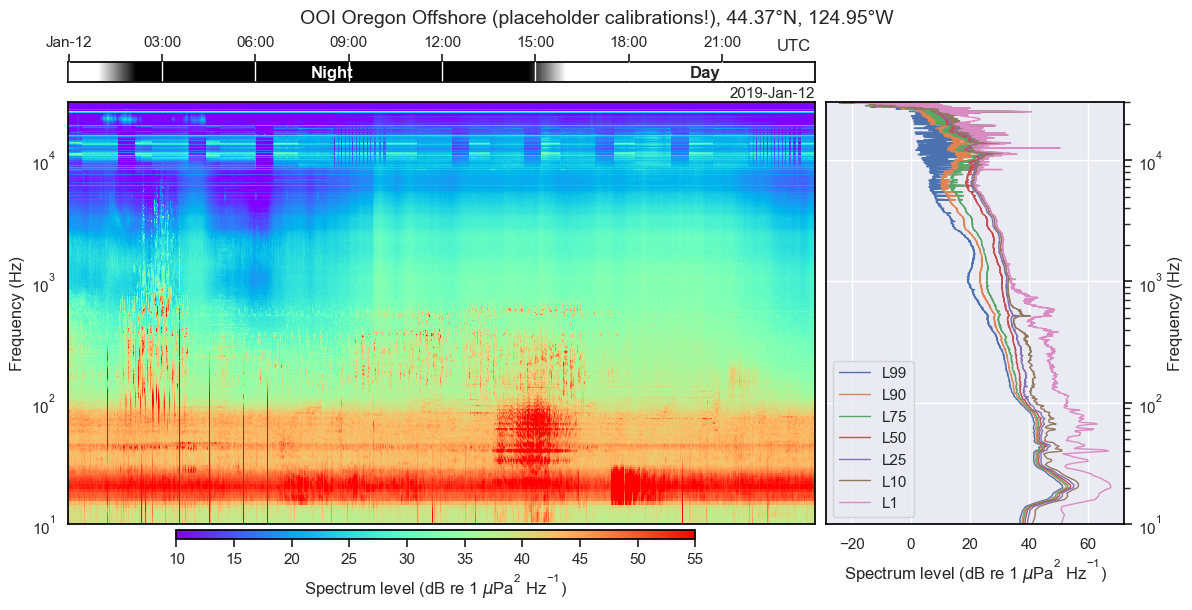

In [25]:
plot_dataset_summary(
    ds,
    lat_lon_for_solpos=(44.37, -124.95),
    title='OOI Oregon Offshore (placeholder calibrations!), 44.37°N, 124.95°W',
    ylim=subset_to,
    cmlim=(10, 55),
    show=True,
)